#### Import libraries

In [2]:
# Imports
# ----------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

#### Import datasets

In [3]:
# Imports
# ----------------

raw_train_df = pd.read_csv(r'data\application_train.csv')
raw_test_df = pd.read_csv(r'data\application_test.csv')

In [4]:
display(raw_train_df.head())

print(f"Dimensions: {raw_train_df.shape[0]} rows × {raw_train_df.shape[1]} columns")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Dimensions: 307511 rows × 122 columns


#### Exploratory Data Analysis

In [5]:
raw_train_df.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

About 24825 from 307511 clients are unreliable.
That's approximately 8.07% of the clients.


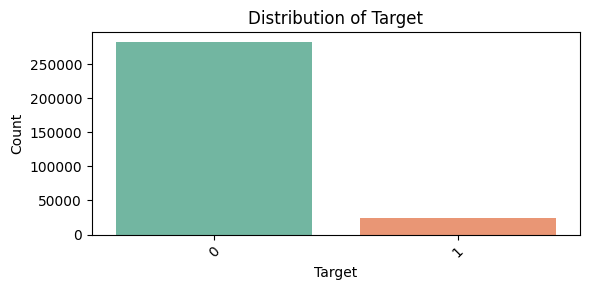

In [6]:
# Target data
# ----------------

target_sum_false = sum(raw_train_df['TARGET'] == 1)
target_sum = len(raw_train_df['TARGET'])
print(f'About {target_sum_false} from {target_sum} clients are unreliable.')
print(f'That\'s approximately {round(target_sum_false/target_sum * 100, 2)}% of the clients.')

plt.figure(figsize=(6, 3))
sns.countplot(x='TARGET', hue='TARGET', data=raw_train_df, palette='Set2', legend=False)
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

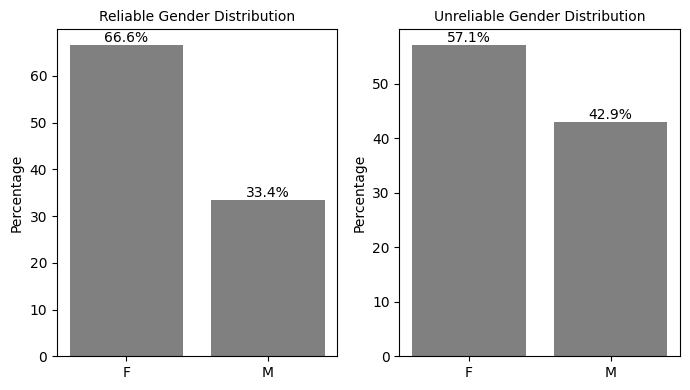

In [7]:
# Gender
# ----------------

raw_train_df['CODE_GENDER'].replace('XNA', 'F', inplace=True)

gender_counts_0 = raw_train_df[raw_train_df['TARGET'] == 0]['CODE_GENDER'].value_counts(normalize=True) * 100
gender_counts_1 = raw_train_df[raw_train_df['TARGET'] == 1]['CODE_GENDER'].value_counts(normalize=True) * 100

def plot_gender(df, text, ax):
    bars = axes[ax].bar(df.index, df.values, color='grey')
    axes[ax].set_title(text + ' Gender Distribution', fontsize=10)
    axes[ax].set_ylabel('Percentage', fontsize=10)

    for bar in bars:
        height = bar.get_height()
        axes[ax].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

plot_gender(gender_counts_0, 'Reliable', 0)
plot_gender(gender_counts_1, 'Unreliable', 1)

plt.tight_layout()
plt.show()

Some of the men are less reliable than women, with 42.9% of the unreliable client data being men, while only 33.4% are reliable. This disparity suggests that gender may be a factor in determining reliability, with a higher proportion of men among the unreliable individuals compared to the reliable ones.

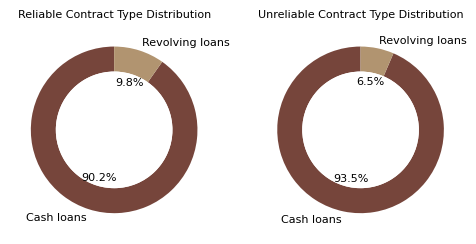

In [8]:
# Contract type
# ----------------

contract_type_counts_0 = raw_train_df[raw_train_df['TARGET'] == 0]['NAME_CONTRACT_TYPE'].value_counts()
contract_type_counts_1 = raw_train_df[raw_train_df['TARGET'] == 1]['NAME_CONTRACT_TYPE'].value_counts()

def plot_contract_type(df, text, plot):
    plt.subplot(1, 2, plot)
    plt.pie(df, labels=df.index, autopct='%1.1f%%', startangle=90,
            colors=['#76453B','#B19470'], wedgeprops=dict(width=0.3), textprops={'fontsize': 8})

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(text + ' Contract Type Distribution', fontsize=8)

plt.figure(figsize=(5, 3))

plot_contract_type(contract_type_counts_0, 'Reliable', 1)
plot_contract_type(contract_type_counts_1, 'Unreliable', 2)

plt.tight_layout()
plt.show()

The approximately 3% difference in the proportion of revolving loans between reliable and unreliable data does not provide insights into the influence of contract type on reliability. This suggests that while there may be some variation in the distribution of contract types between reliable and unreliable individuals, it may not be a significant factor in determining reliability on its own.

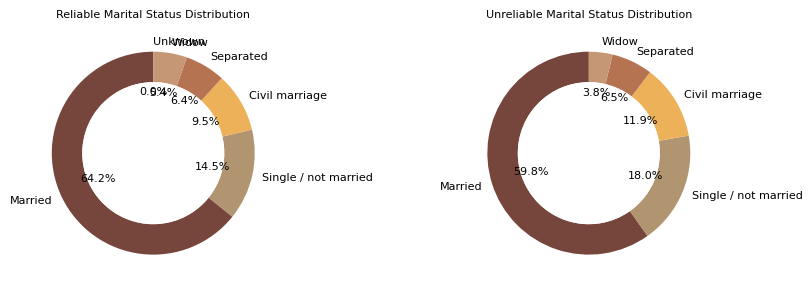

In [9]:
# Marital status
# ----------------

marriage_counts_0 = raw_train_df[raw_train_df['TARGET'] == 0]['NAME_FAMILY_STATUS'].value_counts()
marriage_counts_1 = raw_train_df[raw_train_df['TARGET'] == 1]['NAME_FAMILY_STATUS'].value_counts()

plt.figure(figsize=(9, 3))

def plot_marital_status(df, text, plot):
        plt.subplot(1, 2, plot)
        plt.pie(df, labels=df.index, autopct='%1.1f%%', startangle=90,
                colors=['#76453B','#B19470', '#ECB159', '#B67352', '#C69774'], wedgeprops=dict(width=0.3), textprops={'fontsize': 8})

        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.title(text+ ' Marital Status Distribution', fontsize=8)


plot_marital_status(marriage_counts_0, 'Reliable', 1)
plot_marital_status(marriage_counts_1, 'Unreliable', 2)

plt.tight_layout()
plt.show()

In [10]:
married = ['Married', 'Civil marriage']
raw_train_df['NAME_FAMILY_STATUS'] = ['Married' if status in married else 'Not married' for status in
                                      raw_train_df['NAME_FAMILY_STATUS']]

grouped = raw_train_df.groupby('TARGET')['NAME_FAMILY_STATUS'].value_counts(normalize=True) * 100

marital_df = pd.DataFrame(grouped).rename(columns={'NAME_FAMILY_STATUS': 'proportion'}).reset_index()
marital_df['proportion'] = marital_df['proportion'].apply(lambda x: f'{x:.2f}%')

marital_df = marital_df.rename(columns={'TARGET': 'Target', 'NAME_FAMILY_STATUS': 'Status', 'proportion': 'Percentage'})

marital_df

,Target,Status,Percentage
0,0,Married,73.72%
1,0,Not married,26.28%
2,1,Married,71.75%
3,1,Not married,28.25%


Similarly, the comparison between married and unmarried individuals reveals a marginal difference of approximately 2% in reliability. This suggests that marital status alone may not be a strong determinant of reliability.

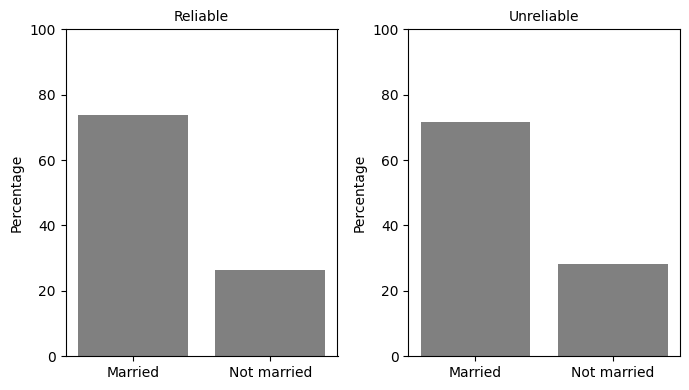

In [11]:
marital_df['Percentage'] = marital_df['Percentage'].astype(str)

marital_df_target_0 = marital_df[marital_df['Target'] == 0]
marital_df_target_1 = marital_df[marital_df['Target'] == 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

axes[0].bar(marital_df_target_0['Status'], marital_df_target_0['Percentage'].str.rstrip('%').astype(float), color='grey')
axes[0].set_title('Reliable', fontsize = 10)
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(0, 100)

axes[1].bar(marital_df_target_1['Status'], marital_df_target_1['Percentage'].str.rstrip('%').astype(float), color='grey')
axes[1].set_title('Unreliable', fontsize = 10)
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)


plt.tight_layout()
plt.show()

In [12]:
# Age group
# ----------------

raw_train_df['DAYS_BIRTH'] =  raw_train_df['DAYS_BIRTH']* -1
raw_train_df['AGE'] =  np.floor(raw_train_df['DAYS_BIRTH'] / 365).astype(int)

bins = [17, 35, 55, 100]
labels = ['Young Adult', 'Middle Age', 'Old']

raw_train_df['AGE'] = pd.cut(raw_train_df['AGE'], bins=bins, labels=labels, right=False)
raw_train_df.drop(columns='DAYS_BIRTH', inplace=True)

In [13]:
grouped_age = raw_train_df.groupby('TARGET')['AGE'].value_counts(normalize=True) * 100

age_df = pd.DataFrame(grouped_age).rename(columns={'AGE': 'proportion'}).reset_index()
age_df['proportion'] = age_df['proportion'].apply(lambda x: f'{x:.2f}%')

age_df = age_df.rename(columns={'TARGET': 'Target', 'AGE': 'Age Group', 'proportion': 'Percentage'})

age_df

,Target,Age Group,Percentage
0,0,Middle Age,50.34%
1,0,Young Adult,26.61%
2,0,Old,23.04%
3,1,Middle Age,48.46%
4,1,Young Adult,37.11%
5,1,Old,14.44%


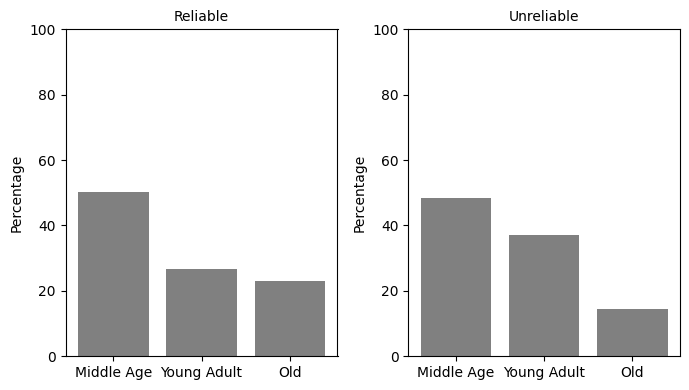

In [14]:
age_df['Percentage'] = age_df['Percentage'].astype(str)

age_df_target_0 = age_df[age_df['Target'] == 0]
age_df_target_1 = age_df[age_df['Target'] == 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))

def plot_age_group(df, text, ax):
    axes[ax].bar(df['Age Group'], df['Percentage'].str.rstrip('%').astype(float), color='grey')
    axes[ax].set_title(text, fontsize=10)
    axes[ax].set_ylabel('Percentage')
    axes[ax].set_ylim(0, 100)

plot_age_group(age_df_target_0, 'Reliable', 0)
plot_age_group(age_df_target_1, 'Unreliable', 1)

plt.tight_layout()
plt.show()

The data indicates that Middle Age individuals are predominant among both reliable and unreliable borrowers. However, Young Adults are relatively less represented among reliable borrowers. We need to focus more on risk mitigation strategies tailored to Young Adult borrowers, and do targeted marketing efforts aimed at Middle Age individuals to attract new customer with low-risk profile.

#### Preprocessing

In [15]:
null_counts = raw_train_df.isna().sum()
null_percentage = (null_counts / len(raw_train_df)) * 100

null_df = pd.DataFrame({'Column': null_counts.index, 'Total Null Data': null_counts.values, 'Percentage': null_percentage.values})
null_df['Percentage'] = null_df['Percentage'].round(2)

null_df = null_df.sort_values(by='Total Null Data', ascending=False)
null_df.head()

,Column,Total Null Data,Percentage
61,COMMONAREA_MODE,214865,69.87
47,COMMONAREA_AVG,214865,69.87
75,COMMONAREA_MEDI,214865,69.87
83,NONLIVINGAPARTMENTS_MEDI,213514,69.43
55,NONLIVINGAPARTMENTS_AVG,213514,69.43


In [16]:
null_above_40 = null_df[null_df['Percentage'] > 40]

print("Number of columns with null values above 40 percent:", len(null_above_40))

Number of columns with null values above 40 percent: 49


In [17]:
columns_to_drop = null_above_40['Column'].tolist()
train_df = raw_train_df.drop(columns=columns_to_drop)
train_df = train_df.drop(columns='SK_ID_CURR')

print("Shape of cleaned DataFrame after dropping columns with more than 40% null values:", train_df.shape)

Shape of cleaned DataFrame after dropping columns with more than 40% null values: (307511, 72)


In [18]:
display(train_df.tail())
print(f"Dimensions: {train_df.shape[0]} rows × {train_df.shape[1]} columns")

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Young Adult
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Old
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,Middle Age
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Young Adult
307510,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,...,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0,Middle Age


Dimensions: 307511 rows × 72 columns


In [19]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       307511 non-null  int64   
 1   NAME_CONTRACT_TYPE           307511 non-null  object  
 2   CODE_GENDER                  307511 non-null  object  
 3   FLAG_OWN_CAR                 307511 non-null  object  
 4   FLAG_OWN_REALTY              307511 non-null  object  
 5   CNT_CHILDREN                 307511 non-null  int64   
 6   AMT_INCOME_TOTAL             307511 non-null  float64 
 7   AMT_CREDIT                   307511 non-null  float64 
 8   AMT_ANNUITY                  307499 non-null  float64 
 9   AMT_GOODS_PRICE              307233 non-null  float64 
 10  NAME_TYPE_SUITE              306219 non-null  object  
 11  NAME_INCOME_TYPE             307511 non-null  object  
 12  NAME_EDUCATION_TYPE          307511 non-null

In [20]:
y = train_df['TARGET']
train_df = train_df.drop(columns='TARGET')

In [21]:
# Processing data
# ----------------

numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

train_df[numerical_cols] = numerical_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = categorical_imputer.fit_transform(train_df[categorical_cols])

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(train_df[categorical_cols])
encoded_categorical = pd.DataFrame(encoded_categorical.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
train_df = pd.concat([train_df, encoded_categorical], axis=1)
train_df = train_df.drop(categorical_cols, axis=1)

scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

In [22]:
train_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,AGE_Middle Age,AGE_Old,AGE_Young Adult
0,-0.577538,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,-0.456215,0.379837,0.579154,0.001803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.577538,0.426792,1.725450,0.592677,1.600698,-1.252750,-0.460115,1.078697,1.790855,0.001803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.577538,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,-0.453299,0.206116,0.306869,0.001803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.577538,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-0.473217,-1.375829,0.369143,0.001803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.577538,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,-0.473210,0.191639,-0.307263,0.001803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Oversampling and Undersampling

Oversampling and undersampling are techniques to handle class imbalance in datasets.

Oversampling: Increases minority class instances, reducing bias towards the majority. This can be done by duplicating instances or generating synthetic ones (e.g., using SMOTE).

Undersampling: Decreases majority class instances, preventing model bias towards it. This is done by randomly selecting a subset from the majority class.

In [23]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [24]:
X = train_df.abs()
# y already defined

In [25]:
# Oversampling minority data
# ----------------

oversampler = RandomOverSampler(sampling_strategy='minority')
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

In [26]:
# Undersampling majority data
# ----------------

undersampler = RandomUnderSampler(sampling_strategy='majority')
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

#### Features Selection

In [27]:
# Features selection
# ----------------

num_features = 150

selector_over = SelectKBest(score_func=chi2, k=num_features)
X_over_selected = selector_over.fit_transform(X_oversampled, y_oversampled)
selected_features_indices_over = selector_over.get_support(indices=True)
selected_features_over = X.columns[selected_features_indices_over]


selector_under = SelectKBest(score_func=chi2, k=num_features)
X_under_selected = selector_under.fit_transform(X_undersampled, y_undersampled)
selected_features_indices_under = selector_under.get_support(indices=True)
selected_features_under = X.columns[selected_features_indices_under]

print("Selected Features for Oversampled Data:", selected_features_over.tolist())
print("Selected Features for Undersampled Data:", selected_features_under.tolist())

Selected Features for Oversampled Data: ['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_

In [28]:
# Split train and validation data
# ----------------

from sklearn.model_selection import train_test_split

X_overtrain, X_overval, y_overtrain, y_overval = train_test_split(X_over_selected, y_oversampled, test_size=0.2, random_state=42)
X_undertrain, X_underval, y_undertrain, y_underval = train_test_split(X_under_selected, y_undersampled, test_size=0.2, random_state=42)

#### Model Training

In [29]:
# Oversampled Logistic Regression Model
# ----------------

from sklearn.linear_model import LogisticRegression

logr_model_over = LogisticRegression(max_iter=10000)
logr_model_over.fit(X_overtrain, y_overtrain)

logr_y_pred_over = logr_model_over.predict(X_overval)

print("Oversampled")
print("----------------")
logr_accuracy = accuracy_score(y_overval, logr_y_pred_over)
print("Logistic Regression Accuracy:", logr_accuracy)

print("Logistic Regression Classification Report:")
print(classification_report(y_overval, logr_y_pred_over))

print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_overval, logr_y_pred_over))


Oversampled
----------------
Logistic Regression Accuracy: 0.639363254477117
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     56536
           1       0.64      0.63      0.64     56539

    accuracy                           0.64    113075
   macro avg       0.64      0.64      0.64    113075
weighted avg       0.64      0.64      0.64    113075

Logistic Regression Confusion Matrix:
[[36455 20081]
 [20698 35841]]


In [30]:
# Undersampled Logistic Regression Model
# ----------------

logr_model_under = LogisticRegression(max_iter=10000)
logr_model_under.fit(X_undertrain, y_undertrain)

logr_y_pred_under = logr_model_under.predict(X_underval)

print("Undersampled")
print("----------------")
logr_accuracy = accuracy_score(y_underval, logr_y_pred_under)
print("Logistic Regression Accuracy:", logr_accuracy)

print("Logistic Regression Classification Report:")
print(classification_report(y_underval, logr_y_pred_under))

print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_underval, logr_y_pred_under))


Undersampled
----------------
Logistic Regression Accuracy: 0.6329305135951662
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      4953
           1       0.64      0.62      0.63      4977

    accuracy                           0.63      9930
   macro avg       0.63      0.63      0.63      9930
weighted avg       0.63      0.63      0.63      9930

Logistic Regression Confusion Matrix:
[[3182 1771]
 [1874 3103]]


In [31]:
# Oversampled Random Forest Classifier Model
# ----------------

from sklearn.ensemble import RandomForestClassifier

rf_model_over = RandomForestClassifier(max_depth=20)
rf_model_over.fit(X_overtrain, y_overtrain)

rf_y_pred_over = rf_model_over.predict(X_overval)

print("Oversampled")
print("----------------")
rf_accuracy = accuracy_score(y_overval, rf_y_pred_over)
print("Random Forest Accuracy:", rf_accuracy)

print("Random Forest Classification Report: ")
print(classification_report(y_overval, rf_y_pred_over))

print("Random Forest Confusion Matrix: ")
print(confusion_matrix(y_overval, rf_y_pred_over))

Oversampled
----------------
Random Forest Accuracy: 0.9106787530400177
Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     56536
           1       0.89      0.94      0.91     56539

    accuracy                           0.91    113075
   macro avg       0.91      0.91      0.91    113075
weighted avg       0.91      0.91      0.91    113075

Random Forest Confusion Matrix: 
[[49971  6565]
 [ 3535 53004]]


In [32]:
# Undersampled Random Forest Classifier Model
# ----------------

rf_model_under = RandomForestClassifier()
rf_model_under.fit(X_undertrain, y_undertrain)

rf_y_pred_under = rf_model_under.predict(X_underval)

print("Undersampled")
print("----------------")
rf_accuracy = accuracy_score(y_underval, rf_y_pred_under)
print("Random Forest Accuracy:", rf_accuracy)

print("Random Forest Classification Report: ")
print(classification_report(y_underval, rf_y_pred_under))

print("Random Forest Confusion Matrix: ")
print(confusion_matrix(y_underval, rf_y_pred_under))

Undersampled
----------------
Random Forest Accuracy: 0.646122860020141
Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      4953
           1       0.66      0.62      0.64      4977

    accuracy                           0.65      9930
   macro avg       0.65      0.65      0.65      9930
weighted avg       0.65      0.65      0.65      9930

Random Forest Confusion Matrix: 
[[3326 1627]
 [1887 3090]]


In [33]:
# Oversampled XGBoost Classification Model
# ----------------

from xgboost import XGBClassifier

xgb_model_over = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model_over.fit(X_overtrain, y_overtrain)

xgb_y_pred_over = xgb_model_over.predict(X_overval)

print("Oversampled")
print("----------------")
xgb_accuracy = accuracy_score(y_overval, xgb_y_pred_over)
print("XGBoost Classification Accuracy:", xgb_accuracy)

print("XGBoost Classification Classification Report:")
print(classification_report(y_overval, xgb_y_pred_over))

print("XGBoost Classification Confusion Matrix:")
print(confusion_matrix(y_overval, xgb_y_pred_over))

Oversampled
----------------
XGBoost Classification Accuracy: 0.729586557594517
XGBoost Classification Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73     56536
           1       0.73      0.72      0.73     56539

    accuracy                           0.73    113075
   macro avg       0.73      0.73      0.73    113075
weighted avg       0.73      0.73      0.73    113075

XGBoost Classification Confusion Matrix:
[[41584 14952]
 [15625 40914]]


In [34]:
# Undersampled XGBoost Classification Model
# ----------------

xgb_model_under = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model_under.fit(X_undertrain, y_undertrain)

xgb_y_pred_under = xgb_model_under.predict(X_underval)

print("Undersampled")
print("----------------")
xgb_accuracy = accuracy_score(y_underval, xgb_y_pred_under)
print("XGBoost Classification Accuracy:", xgb_accuracy)

print("XGBoost Classification Classification Report:")
print(classification_report(y_underval, xgb_y_pred_under))

print("XGBoost Classification Confusion Matrix:")
print(confusion_matrix(y_underval, xgb_y_pred_under))

Undersampled
----------------
XGBoost Classification Accuracy: 0.6450151057401813
XGBoost Classification Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      4953
           1       0.65      0.63      0.64      4977

    accuracy                           0.65      9930
   macro avg       0.65      0.65      0.64      9930
weighted avg       0.65      0.65      0.64      9930

XGBoost Classification Confusion Matrix:
[[3278 1675]
 [1850 3127]]


#### Test Data Preprocessing and Modelling

In [35]:
display(raw_test_df.head())

print(f"Dimensions: {raw_test_df.shape[0]} rows × {raw_test_df.shape[1]} columns")

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Dimensions: 48744 rows × 121 columns


In [36]:
test_df = raw_test_df.drop(columns=columns_to_drop)

print("Shape of cleaned DataFrame after dropping columns with more than 40% null values:", test_df.shape)

Shape of cleaned DataFrame after dropping columns with more than 40% null values: (48744, 72)


In [37]:
# Apply the same preprocessing steps to the test data as done for the training data
# ----------------

test_df['CODE_GENDER'].replace('XNA', 'F', inplace=True)

test_df['NAME_FAMILY_STATUS'] = ['Married' if status in married else 'Not married' for status in test_df['NAME_FAMILY_STATUS']]

test_df['DAYS_BIRTH'] =  test_df['DAYS_BIRTH']* -1
test_df['AGE'] =  np.floor(test_df['DAYS_BIRTH'] / 365).astype(int)

test_df['AGE'] = pd.cut(test_df['AGE'], bins=bins, labels=labels, right=False)
test_df.drop(columns='DAYS_BIRTH', inplace=True)

test_df[numerical_cols] = numerical_imputer.transform(test_df[numerical_cols])
test_df[categorical_cols] = categorical_imputer.transform(test_df[categorical_cols])

encoded_categorical_test = encoder.transform(test_df[categorical_cols])
encoded_categorical_test = pd.DataFrame(encoded_categorical_test.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

test_df = pd.concat([test_df, encoded_categorical_test], axis=1)
test_df = test_df.drop(categorical_cols, axis=1)

test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

In [38]:
X_test = test_df.drop(columns='SK_ID_CURR').abs()
X_test_over_selected = selector_over.transform(X_test)

In [39]:
# Model testing
# ----------------

y_test = xgb_model_over.predict(X_test_over_selected)

In [40]:
predictions_with_id = pd.DataFrame({'SK_ID_CURR': test_df['SK_ID_CURR'], 'TARGET': y_test})
predictions_with_id

,SK_ID_CURR,TARGET
0,100001,1
1,100005,1
2,100013,0
3,100028,0
4,100038,0
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0


In [41]:
predictions_with_id.to_csv('preds.csv', index=False)